# Cartpole Environment

In [2]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""

import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np


class CartPoleEnv(gym.Env):
    """
    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along
        a frictionless track. The pendulum starts upright, and the goal is to
        prevent it from falling over by increasing and reducing the cart's
        velocity.
    Source:
        This environment corresponds to the version of the cart-pole problem
        described by Barto, Sutton, and Anderson
    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        Note: The amount the velocity that is reduced or increased is not
        fixed; it depends on the angle the pole is pointing. This is because
        the center of gravity of the pole increases the amount of energy needed
        to move the cart underneath it
    Reward:
        Reward is 1 for every step taken, including the termination step
    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
    Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of
        the display).
        Episode length is greater than 200.
        Solved Requirements:
        Considered solved when the average return is greater than or equal to
        195.0 over 100 consecutive trials.
    """

    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 50
    }

    def __init__(self):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = (self.masspole + self.masscart)
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = (self.masspole * self.length)
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates
        self.kinematics_integrator = 'euler'

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds.
        high = np.array([self.x_threshold * 2,
                         np.finfo(np.float32).max,
                         self.theta_threshold_radians * 2,
                         np.finfo(np.float32).max],
                        dtype=np.float32)

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.seed()
        self.viewer = None
        self.state = None

        self.steps_beyond_done = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        err_msg = "%r (%s) invalid" % (action, type(action))
        assert self.action_space.contains(action), err_msg

        x, x_dot, theta, theta_dot = self.state
        force = self.force_mag if action == 1 else -self.force_mag
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (force + self.polemass_length * theta_dot ** 2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (self.length * (4.0 / 3.0 - self.masspole * costheta ** 2 / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == 'euler':
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot)

        done = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        if not done:
            reward = 1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            if self.steps_beyond_done == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned done = True. You "
                    "should always call 'reset()' once you receive 'done = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_done += 1
            reward = 0.0

        return np.array(self.state), reward, done, {}

    def reset(self):
        self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        self.steps_beyond_done = None
        return np.array(self.state)

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        world_width = self.x_threshold * 2
        scale = screen_width/world_width
        carty = 100  # TOP OF CART
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)
            l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
            axleoffset = cartheight / 4.0
            cart = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.carttrans = rendering.Transform()
            cart.add_attr(self.carttrans)
            self.viewer.add_geom(cart)
            l, r, t, b = -polewidth / 2, polewidth / 2, polelen - polewidth / 2, -polewidth / 2
            pole = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            pole.set_color(.8, .6, .4)
            self.poletrans = rendering.Transform(translation=(0, axleoffset))
            pole.add_attr(self.poletrans)
            pole.add_attr(self.carttrans)
            self.viewer.add_geom(pole)
            self.axle = rendering.make_circle(polewidth/2)
            self.axle.add_attr(self.poletrans)
            self.axle.add_attr(self.carttrans)
            self.axle.set_color(.5, .5, .8)
            self.viewer.add_geom(self.axle)
            self.track = rendering.Line((0, carty), (screen_width, carty))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

            self._pole_geom = pole

        if self.state is None:
            return None

        # Edit the pole polygon vertex
        pole = self._pole_geom
        l, r, t, b = -polewidth / 2, polewidth / 2, polelen - polewidth / 2, -polewidth / 2
        pole.v = [(l, b), (l, t), (r, t), (r, b)]

        x = self.state
        cartx = x[0] * scale + screen_width / 2.0  # MIDDLE OF CART
        self.carttrans.set_translation(cartx, carty)
        self.poletrans.set_rotation(-x[2])

        return self.viewer.render(return_rgb_array=mode == 'rgb_array')

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None

# Actor

In [3]:
import numpy as np

# 0 = left
# 1 = nothing
# 2 = right
class Actor():
    
    def __init__(self, alpha=0.01, epsilon = 1.0, gamma = 1.0):
        self.policy_params = np.zeros(8)
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.action_values = [0,1]
    
    def get_x(self,observation,a=None):
        if a == 0:
            return np.array([observation[0],observation[1],observation[2],observation[3],observation[0],observation[1],observation[2],observation[3]])
        elif a == 1:
            return np.array([observation[0],observation[1],observation[2],observation[3],-observation[0],-observation[1],-observation[2],-observation[3]])
        else:
            raise ValueError('Invalid Action!')
    
    def get_action(self,observation):
        xs=np.array([self.get_x(observation,a) for a in self.action_values]) # shape: 2,4
        activations = self.policy_params.dot(xs.T) # d(1,4) * d(2,4)
        probabilities = np.exp(activations)/np.sum(np.exp(activations))
        if np.isnan(probabilities).any():
            if np.isnan(probabilities[0]):
                probabilities[0] = 0.0
                probabilities[1] = 1.0
            else:
                probabilities[0] = 1.0
                probabilities[1] = 0.0
        return np.random.choice(self.action_values,p=probabilities)
    
    def get_probabilities(self,observation):
        xs=np.array([self.get_x(observation,a) for a in self.action_values]) # shape: 2,4
        activations = self.policy_params.dot(xs.T) # d(1,4) * d(2,4)
        probabilities = np.exp(activations)/np.sum(np.exp(activations))
        if np.isnan(probabilities).any():
            if np.isnan(probabilities[0]):
                probabilities[0] = 0.0
                probabilities[1] = 1.0
            else:
                probabilities[0] = 1.0
                probabilities[1] = 0.0
        return probabilities
    
    def eligibility_vector(self, action, observation):
        # d(1,2) x d(2,4)
        return self.get_x(observation, action) - sum([self.get_x(observation,self.action_values[b])*self.get_probabilities(observation)[b] for b in range(len(self.action_values))])
    
    def learn(self, observation, action, G, discount):
        self.policy_params += self.alpha *  G * discount * self.eligibility_vector(action, observation)

# 20 Sim Average with decreasing LRs

In [11]:
import gym

# env = gym.make('CartPole-v0')
env = CartPoleEnv()
# INPUTS
N_SIMULATIONS = 20
N_EPISODES=1000
MAX_LENGTH=500
GAMMA = 1.0
#
#
#
list_episode_lengths = []
try:
    for k in range(N_SIMULATIONS):
        episode_lengths = []
        actor = Actor(alpha=0.001)
        for episode in range(N_EPISODES):
            if (episode+1) % 200 == 0:
                actor.alpha /= 3
            observation = env.reset()
            rewards = [0]
            actions = []
            observations = []
            observations.append(observation)
            episode_length = 0
            while True:
    #             env.render()
                action = actor.get_action(observation)
                observation, reward, done, info = env.step(action)
                rewards.append(reward)
                observations.append(observation)
                actions.append(action)
                episode_length+=1
                if done:
#                     print("episode finished after {} timesteps".format(episode_length))
                    break
                if episode_length == MAX_LENGTH:
#                     print("episode did not finish after {} timesteps".format(episode_length))
                    break
            episode_lengths.append(episode_length)

            G = [rewards[k]*GAMMA**(k-1) for k in range(1,episode_length)]
            for t in range(episode_length):
                gt = np.sum(G[t:])*GAMMA**(-t)
                actor.learn(observations[t], actions[t], gt, GAMMA**t)
        saved_actor = actor
        list_episode_lengths.append(episode_lengths)
        print(k)
except AssertionError as error:
    print(error)
finally:
    env.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0, 0.5, 'Timesteps')

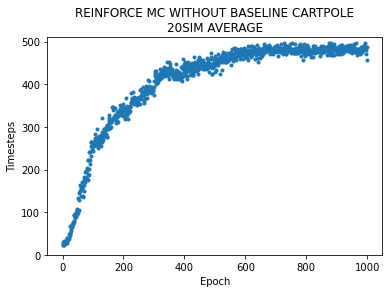

In [12]:
import matplotlib.pyplot as plt
mean_episode_lengths = np.mean(np.asarray(list_episode_lengths),axis=0)

fig, ax = plt.subplots()
ax.plot(range(len(mean_episode_lengths)),mean_episode_lengths, ".")
ax.set_ylim(0,510)
ax.set_title("REINFORCE MC WITHOUT BASELINE CARTPOLE\n{}SIM AVERAGE".format(N_SIMULATIONS))
ax.set_xlabel("Epoch")
ax.set_ylabel("Timesteps")

In [14]:
import pickle
with open('NO_Baseline_optimal_20SIM.pickle', 'wb') as handle:
    pickle.dump(mean_episode_lengths, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('NO_Baseline_optimal_20SIM.pickle', 'rb') as handle:
    mean_episode_lengths = pickle.load(handle)

In [11]:
import gym

# env = gym.make('CartPole-v0')
env = CartPoleEnv()

GAMMA = 1.0
try:
    observation = env.reset()
    rewards = [0]
    actions = []
    observations = []
    observations.append(observation)
    episode_length = 0
    while episode_length < 2000:
        env.render()
        action = saved_actor.get_action(observation)
        observation, reward, done, info = env.step(action)
        rewards.append(reward)
        observations.append(observation)
        actions.append(action)
        episode_length+=1
        if done:
            print("episode finished after {} timesteps".format(episode_length))
            break
except AssertionError as error:
    print(error)
finally:
    env.close()

episode finished after 169 timesteps


# LR optimization

In [6]:
import gym

# env = gym.make('CartPole-v0')
env = CartPoleEnv()
# INPUTS
N_SIMULATIONS = 5
N_EPISODES=300
MAX_LENGTH=300
GAMMA = 1.0
lrs = [1.0, 0.01, 0.001, 0.0001, 0.00001]

#
#
#
list_episode_lengths = np.zeros((len(lrs),N_SIMULATIONS,N_EPISODES))
try:
    for i, alpha in enumerate(lrs):
        for k in range(N_SIMULATIONS):
            episode_lengths = []
            actor = Actor(alpha=alpha)
            for episode in range(N_EPISODES):
                observation = env.reset()
                rewards = [0]
                actions = []
                observations = []
                observations.append(observation)
                episode_length = 0
                while True:
        #             env.render()
                    action = actor.get_action(observation)
                    observation, reward, done, info = env.step(action)
                    rewards.append(reward)
                    observations.append(observation)
                    actions.append(action)
                    episode_length += 1
                    if done:
    #                     print("episode finished after {} timesteps".format(episode_length))
                        break
                    if episode_length == MAX_LENGTH:
    #                     print("episode did not finish after {} timesteps".format(episode_length))
                        break
                list_episode_lengths[i, k, episode] = episode_length
                G = [rewards[k]*GAMMA**(k-1) for k in range(1,episode_length)]
                # R1 +yR2 + y^2R3 + ...
                # R2 + yR3 + ...
                for t in range(episode_length):
                    gt = np.sum(G[t:])*GAMMA**(-t)
                    actor.learn(observations[t], actions[t], gt, GAMMA**t)
            saved_actor = actor

            print(k)
except AssertionError as error:
    print(error)
finally:
    env.close()

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


In [9]:
mean_episode_lengths = np.mean(np.asarray(list_episode_lengths),axis=1)
mean_episode_lengths.shape

(5, 300)

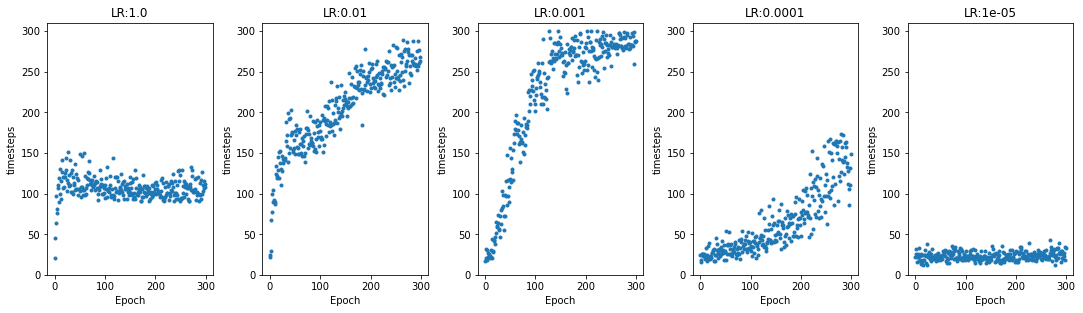

In [14]:
import matplotlib.pyplot as plt

mean_episode_lengths = np.mean(np.asarray(list_episode_lengths),axis=1)

fig, ax = plt.subplots(1,len(lrs))
plt.subplots_adjust(right = 2.5, top = 1, wspace = 0.3, hspace = 0.6)
for i, alpha in enumerate(lrs):
    ax[i].plot(range(N_EPISODES),mean_episode_lengths[i], ".")
    ax[i].set_ylim(0,310)
    ax[i].set_title("LR:"+str(alpha))
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("timesteps")